# Flow and transport problem

In this tutorial we investigate the transport problem where the advective field is computed with a Darcy model.

## Exercise 2

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$.
We define also $(0, T)$ the time interval, being $T$ the final time.

Given 
$k$ the matrix permeability and $f = 0$ the source term, we want to solve the following problem: find $p$ such that
find $p$ such that
$$
\nabla \cdot (- k\nabla p) = f
\quad \text{in } \Omega
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \qquad p = 1 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot k \nabla p = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega$$
The permeability matrix is given by
$$
k(x, y) =
\left\{
\begin{array}{ll}
10 \quad \text{if } y > 0.5\\
1 \quad \text{ else}
\end{array}
\right.
$$

Given the flux $q$ computed by the previous model, we want to solve the following problem: find $c$ such that
$$
\partial_t c + \nabla \cdot (qc) = 0
\quad \text{in } \Omega \times (0, T)
$$
with boundary conditions set on the inflow of the domain:
$$ c = c_I \quad \text{ on } \partial \Omega \times (0, T)$$
and initial condition for the contration
$$ c(x, 0) = c_0(x) \quad \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

Before creating the grid we import NumPy, the SciPy sparse library and PorePy.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp
import pygeon as pg

We specify number of cells in each dimension and the physical size of the domain. Then we create a Cartesian grid and compute geometric properties such as face centers, cell volumes etc.

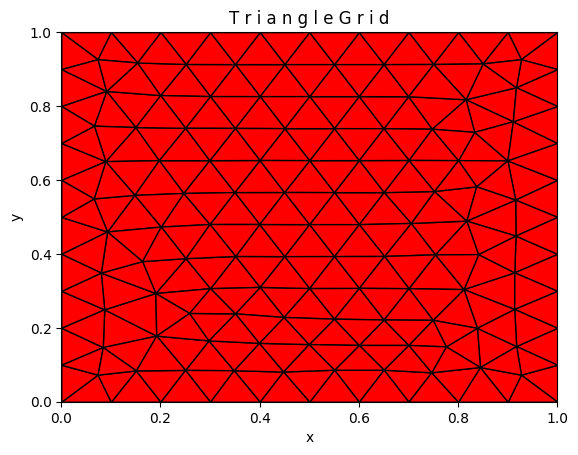

In [2]:
dim = 2
N = [40] * dim
phys_dims = [1] * dim

# sd = pp.CartGrid(N, phys_dims)
# sd.compute_geometry()

mesh_size = 0.1
# creation of the grid
sd = pg.unit_grid(2, mesh_size, as_mdg=False)
# compute the geometrical properties of the grid
sd.compute_geometry()

pp.plot_grid(sd, plot_2d=True)

We first need to solve the Darcy problem, so declare its data.

In [3]:
# Permeability
perm_vals = 10 * (sd.cell_centers[1] > 0.5) + 1 * (sd.cell_centers[1] <= 0.5)
perm = pp.SecondOrderTensor(perm_vals)

# define outflow and inflow type boundary conditions, left and right boundary
b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
b_face_centers = sd.face_centers[:, b_faces]

outflow = np.isclose(b_face_centers[0, :], 1)
inflow = np.isclose(b_face_centers[0, :], 0)

# define the labels and values for the boundary faces
labels = np.array(["neu"] * b_faces.size)
bc_val = np.zeros(sd.num_faces)

labels[np.logical_or(inflow, outflow)] = "dir"
bc_val[b_faces[inflow]] = 1

bc = pp.BoundaryCondition(sd, b_faces, labels)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "bc": bc, "bc_values": bc_val}

We now set the data for the Darcy problem

In [4]:
flow_key = "flow"
flow_data = pp.initialize_default_data(sd, {}, flow_key, parameters)

We now solve the Darcy problem by using the MPFA scheme.

In [5]:
# construct the lhr and rhs from the discretization of the diffusion operator
mpfa = pp.Mpfa(flow_key)
mpfa.discretize(sd, flow_data)
A, b = mpfa.assemble_matrix_rhs(sd, flow_data)

# solve the problem
cell_p = sps.linalg.spsolve(A, b)

# now data contains the discretization matrices build from MPFA
mat_discr = flow_data[pp.DISCRETIZATION_MATRICES][flow_key]

q = mat_discr["flux"] @ cell_p + mat_discr["bound_flux"] @ bc_val

And we export the corresponding solutions.

In [6]:
save = pp.Exporter(sd, "sol_p", folder_name="ex2")
exp_p = save.write_vtu([("cell_p", cell_p)])

We now consider the transport problem where now the advective field is the one computed from the Darcy problem. First we set the data.

In [7]:
# Transport problem
transport_key = "transport"
delta_t = 0.01
num_steps = 100

# Set in the data file the flux
bc_val = np.zeros(sd.num_faces)
bc_val[b_faces[inflow]] = 1

parameters = {"darcy_flux": q, "bc": bc, "bc_values": bc_val}
transport_data = pp.initialize_default_data(sd, {}, transport_key, parameters)

As done in the 1d case, we now construct the upwind matrix and the mass matrix.

In [8]:
# create the upwind and mass matrices
upwind = pp.Upwind(transport_key)

# discretize and get the matrices
upwind.discretize(sd, transport_data)

U, b_upwind = upwind.assemble_matrix_rhs(sd, transport_data)
M = sps.diags(sd.cell_volumes)

Finally, by using the implicit Euler we compute the concentration that is transported in the porous medium

In [9]:
# Initial condition and exporter
c = np.zeros(sd.num_cells)
save = pp.Exporter(sd, "sol_c", folder_name="ex2")
save.write_vtu([("conc", c)], time_step=0)

# IE
S = M + delta_t * U
for i in np.arange(num_steps):
    c = sps.linalg.spsolve(S, M @ c - delta_t * b_upwind)
    save.write_vtu([("conc", c)], time_step=(i + 1) * delta_t)

# export the main pvd file
time = np.arange((num_steps + 1)) * delta_t
save.write_pvd(time)